# Emotion Detector with OpenCV

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from keras.models import model_from_json
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from google.colab.patches import cv2_imshow

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
import io
import html
import time

In [1]:
# Get the classifiers
!wget https://raw.githubusercontent.com/opencv/opencv/4.x/data/haarcascades/haarcascade_frontalface_default.xml

# Get model weights
!wget https://raw.githubusercontent.com/gitshanks/fer2013/master/fer.json

# Get model
# Have to physically download the model
# !wget https://github.com/gitshanks/fer2013/blob/master/fer.h5

--2023-02-07 01:14:27--  https://raw.githubusercontent.com/opencv/opencv/4.x/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.02s   

2023-02-07 01:14:27 (47.1 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]

--2023-02-07 01:14:27--  https://raw.githubusercontent.com/gitshanks/fer2013/master/fer.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent,

## Setup Photo Caputre

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


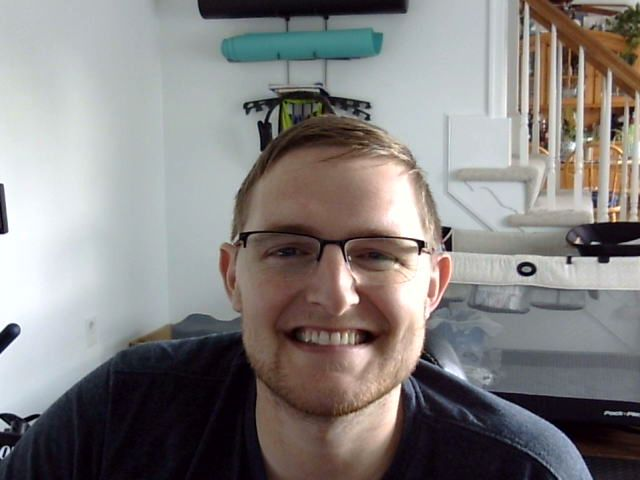

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
# Setup the model
model = model_from_json(open("fer.json", "r").read())
model.load_weights('fer.h5') 

# Instantiate a face cascade
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [ ]:
# Load the image
img = cv2.imread('photo.jpg')
print(img.shape)

# Change the frame to greyscale  
gray_image= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

(480, 640, 3)


1
1/1 [==============================] - 0s 45ms/step
[[4.9865093e-02 3.3366613e-04 4.4945270e-02 6.2809247e-01 5.9218179e-02
  1.9872416e-02 1.9767289e-01]]
happy


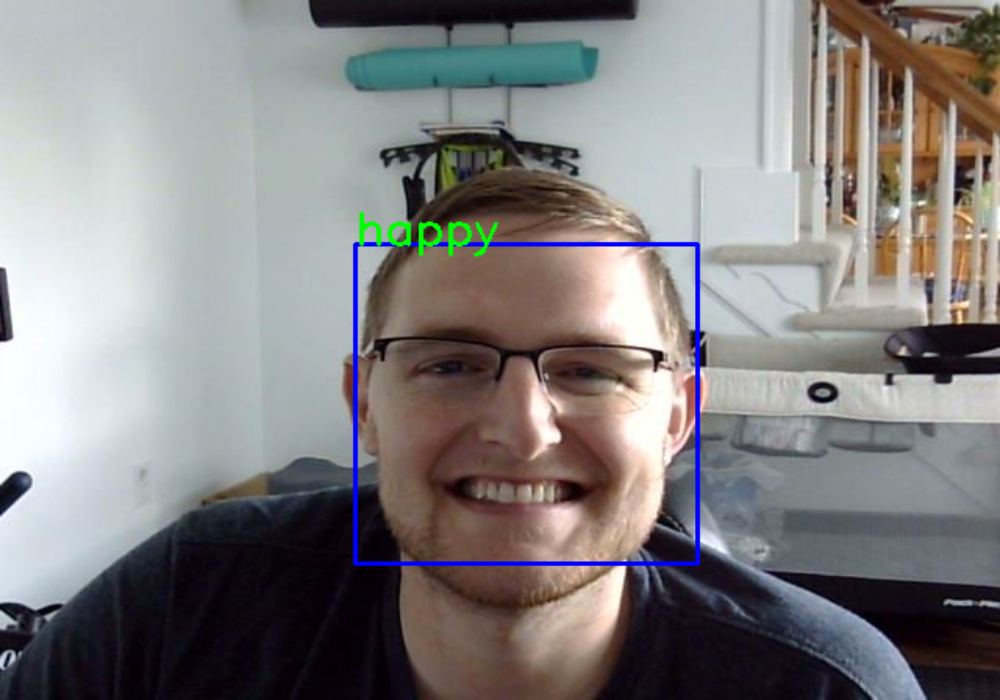

In [ ]:
# We pass the image, scaleFactor and minneighbour
faces_detected = face_cascade.detectMultiScale(gray_image, 1.3, 5)
print(len(faces_detected))

# Draw Triangles around the faces detected
for (x,y,w,h) in faces_detected:
    cv2.rectangle(img, (x,y), (x+w,y+h), (255,0,0), thickness=2)
    roi_gray=gray_image[y:y+h,x:x+w]
    roi_gray=cv2.resize(roi_gray,(48,48))
    
    # Preprocess the image
    image_pixels = tf.keras.preprocessing.image.img_to_array(roi_gray)
    image_pixels = np.expand_dims(image_pixels, axis = 0)
    image_pixels /= 255

    # Model Predictions
    predictions = model.predict(image_pixels)
    print(predictions)

    max_index = np.argmax(predictions[0])
    e_detection = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    e_prediction = e_detection[max_index]
    print(e_prediction)
    
    # Display on image the emotion detected
    cv2.putText(img,e_prediction,(int(x), int(y)),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)

resize_image = cv2.resize(img, (1000, 700))
cv2_imshow(resize_image)